# Experiment 2: |V1| = |V2| Graphs with Increasing Density (without OPTIMAL SOLUTION)
 

In [1]:
# Imports 

import sys
import os
import random
import json
import copy
import time
import pandas as pd
import numpy as np
import math
import networkx as nx 
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations, permutations
from typing import Dict, Union, List, Set
from concurrent.futures import ProcessPoolExecutor
%load_ext cython


## Helper Functions

These functions serves as helper functions for the algorithms and the overall code.

### Crossing functions
- count_crossings - counts crossings, needs a graph object and a pos object.
- cross_count

### Visualization and results
- draw_horizontal_bipartite - visualization function
- visualize_bipartite_graph - visualizer but with only 2 parameters: graph object and bottom nodes
- plot_results - given a data frame, shows the results in table and chart format

### Graph Generators
- generate_bipartite_graph - graph generator
- forced_density_gen_bip_graph - fixed density bipartite graph.
- TBA: generate_sparse_bipartite_graph - for |E|=|V1|+|V2|
### Data Processors
- parse_edges (converts format of edge lists) [{'nodes': ['u0', 'u6']}, ...] --> [(top_node, bottom_node), ...]
- update_positions

### Crossing number Functions

In [2]:
def count_crossings(B, pos):
    """
    Count the number of edge crossings in a bipartite graph layout.
    
    Args:
        B: The bipartite graph (NetworkX object).
        pos: A dictionary with node positions from a layout.
    
    Returns:
        Number of edge crossings in the graph.
    """
    crossings = 0
    edges = list(B.edges())
    # Iterate over all pairs of edges
    # print("DEBUG count_crossings function, length of edges:", len(edges))
    # print("Type of Graph:", B)
    # print("These are its combinations:", len(list(combinations(edges, 2))))
    # print("\n")
    for (u1, v1), (u2, v2) in combinations(edges, 2):
        # Get positions of the edges' endpoints
        try: 
            x1, x2 = pos[u1][0], pos[v1][0]
            x3, x4 = pos[u2][0], pos[v2][0]
        except:
            # print("DEBUG (count_crossings), edges and pos", edges, pos)
            pass
        # Check if the edges cross (intersection in x-coordinates)
        if (x1 < x3 and x2 > x4) or (x1 > x3 and x2 < x4):
            crossings += 1
    return crossings

In [3]:
def binary_search_first_smaller(arr, v, lower_bound, upper_bound, index_references, v_index):
    """
    Binary search to find the rightmost index in 'arr' where the value is smaller than 'v'.
    The search starts from 'lower_bound' and ends at 'upper_bound' to optimize performance.

    Args:
        arr (list[str]): The sorted list of neighbor nodes.
        v (str): The node to compare against.
        lower_bound (int): The starting index for the search.
        upper_bound (int): The ending index for the search.
        index_references (dict): Dictionary mapping nodes to their fixed_layer indices.
        v_index (int): The index of the node 'v' in the fixed layer.

    Returns:
        int: The index of the last element smaller than 'v', or -1 if none exist.
    """
    left, right = lower_bound, upper_bound
    result = -1  # Default to -1 (not found)

    while left <= right:  # Fix condition to include rightmost element
        mid = (left + right) // 2
        # print(f"DEBUG INSIDE BINSEARCH arr[mid]: {arr[mid]}, left: {left}, right: {right}, mid: {mid}")

        if index_references[arr[mid]] < v_index:
            result = mid  # Update result, but keep searching to the right
            left = mid + 1
        else:
            right = mid - 1  # Move left to find a smaller value

    return result  # Final rightmost valid index


def cross_count_optimized(fixed_layer: list[str], free_layer: list[str], edges: list):
    crossing_total = 0
    
    fixed_layer = [f"u{node}" if isinstance(node, int) else node for node in list(fixed_layer) ]
    free_layer =  [f"u{node}" if isinstance(node, int) else node for node in list(free_layer) ]

    fixed_layer_dict = {node: index for index, node in enumerate(fixed_layer)}
    free_layer_dict = {node: index for index, node in enumerate(free_layer)}

    neighbor_dict = {node: [] for node in free_layer}
    easy_free = set(free_layer)
    easy_fixed = set(fixed_layer)

    for edge_data in edges:
        u, v = edge_data["nodes"]
        if u in easy_free and v in easy_fixed:
            neighbor_dict[u].append(v)
        elif v in easy_free and u in easy_fixed:
            neighbor_dict[v].append(u)

    # Sort neighbors based on their position in fixed_layer
    for node in neighbor_dict:
        neighbor_dict[node].sort(key=lambda x: fixed_layer_dict[x])
    # print(f"free{free_layer}, fixed{fixed_layer}")
    # print("DEBUG NEIGHBOR DICT ,",neighbor_dict) #####################################################################################################
    # print("DEBUG: free layer dict", free_layer_dict)
    # print("DEBUG: fixed layer dict", fixed_layer_dict)
    #### CROSSING PROPER ####
    for i, u_node in enumerate(free_layer):
        u_neighbors = neighbor_dict[u_node]
        u_prime_nodes = free_layer[i + 1:]
        # print("")
        # print("u_node ", u_node, ";;;u_prime nodes > u_node: ",u_prime_nodes)
        for u_prime in u_prime_nodes:
          u_prime_neighbors = neighbor_dict[u_prime]
          lb = 0   # 0 indexed as opposed to pseudocode
          ub = len(u_prime_neighbors) - 1  # 0 indexed as opposed to pseudocode
          # print(f"DEBUG u-prime-neighbors: {u_prime_neighbors} of u-prime {u_prime}")
          for v in u_neighbors:
              result = binary_search_first_smaller(u_prime_neighbors, v, lb, ub, fixed_layer_dict, fixed_layer_dict[v]) ##, edit it must be based on indices not the values of the elements themselves
              # print(f"DEBUG result u-node -{u_node}: {result} of v {v} for u-prime-neigh {u_prime_neighbors} of u-prime{u_prime}")
              # lb = result + 1 # result minus 1 because pls see the binary search implementation
              if result != -1:
                crossing_total += result + 1

    return crossing_total


### Visualizers (Graphs and Results)

In [4]:
def draw_horizontal_bipartite(B, top_nodes, bottom_nodes, title, node_order=None):
    """
    Draws the bipartite graph with horizontal layers.
    
    Args:
        B: Bipartite graph.
        top_nodes: Nodes in the top layer (upper row).
        bottom_nodes: Nodes in the bottom layer (lower row).
        title: Title for the plot.
        node_order: Optional reordering for bottom nodes.
    """
    # Apply reordering if provided
    if node_order:
        bottom_nodes = node_order

    # Generate positions for horizontal layout
    pos = {}
    pos.update((node, (i, 0)) for i, node in enumerate(top_nodes))  # Top nodes in the upper row (y=0)
    pos.update((node, (i, -1)) for i, node in enumerate(bottom_nodes))  # Bottom nodes in the lower row (y=-1)

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(
        B,
        pos,
        with_labels=True,
        node_size=700,
        node_color=['lightblue' if node in top_nodes else 'lightgreen' for node in B.nodes()],
        edge_color="gray",
        font_size=10,
        font_color="black"
    )
    plt.title(title, fontsize=14)
    plt.show()

In [5]:
def visualize_bipartite_graph(B, bottom_nodes, message=""):
    """
    Visualize a bipartite graph with horizontal layers.
    
    Args:
        B: The bipartite graph (NetworkX object).
        bottom_nodes: The set of bottom_nodes nodes.
    """
    # Create a bipartite layout with horizontal orientation
    pos = nx.bipartite_layout(B, bottom_nodes, align="horizontal")
    #print("The pos is " + str(pos))
    #horizontal_pos = {node: (y, -x) for node, (x, y) in pos.items()}  # Flip x and y for horizontal layers

    # Draw the graph
    plt.figure(figsize=(10, 6))
    nx.draw(
        B,
        pos=pos,
        with_labels=True,
        node_size=700,
        node_color=['lightblue' if node in bottom_nodes else 'lightgreen' for node in B.nodes()],
        edge_color="gray",
        font_size=10,
        font_color="black",
    )
    plt.title(f"Bipartite Graph Visualization - {message}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Calculate and display number of crossings
    crossings = count_crossings(B, pos)
    print(f"Number of edge crossings: {crossings}")


In [6]:
def plot_results(df, message=""):
    """
    Plots the experiment results. Also includes optional message for the title.
    Each combination of n1 and n2 will have its own line for each heuristic,
    using graph density instead of edge probability on the x-axis.
    """
    # Group by n1, n2 for clarity
    for n1 in df["n1"].unique():
        for n2 in df["n2"].unique():
            subset = df[(df["n1"] == n1) & (df["n2"] == n2)]
            if not subset.empty:
                plt.figure(figsize=(10, 6))
                
                # Compute graph density: Density = p
                density = subset["density"]  # In this case, density = edge probability p
                
                # X-axis: Graph density
                x = density
                
                # Y-axis: Number of crossings
                plt.plot(x, subset["avg_crossings_original"], label="Original Layout", marker="o")
                plt.plot(x, subset["avg_crossings_barycenter"], label="Barycenter Heuristic", marker="s")
                plt.plot(x, subset["avg_crossings_median"], label="Median Heuristic", marker="^")
                plt.plot(x, subset["avg_crossings_sifting"], label="Sifting Heuristic", marker="x")
                # Add labels and title
                plt.title(f"Crossings for n1 = {n1}, n2 = {n2}, {message}")
                plt.xlabel("Graph Density")
                plt.ylabel("Number of Crossings")
                plt.legend()
                plt.grid(True)
                
                # Save result
                plt.savefig(f"exp2_results_{n1}+{n2}.png")
                
                # Show the plot
                plt.show()

### Graph Generators

In [7]:
def generate_bipartite_graph(n1, n2, p):
    """
    Generate a bipartite graph in the specified density.
    
    Args:
        n1: Number of nodes in the first layer.
        n2: Number of nodes in the second layer.
        p: Probability of edge creation.
    
    Returns:
        A tuple (nodes, edges) where:
            - nodes is a list of dictionaries with "id" and "layer".
            - edges is a list of dictionaries with "nodes" as a pair of connected node IDs.
    """
    # print("generating", end="")
    while True:
        # Create a random bipartite graph
        B = nx.bipartite.random_graph(n1, n2, p)
        
        # Check if the graph is connected
        if nx.is_connected(B):
            break  # Only proceed if the graph is connected
    
    # Separate the nodes into layers
    top_nodes, bottom_nodes = nx.algorithms.bipartite.sets(B)
    
    # Create the nodes list with layer information
    nodes = []
    for node in top_nodes:
        nodes.append({"id": f"u{node}", "depth": 0})
    for node in bottom_nodes:
        nodes.append({"id": f"u{node}", "depth": 1})
    
    # Create the edges list
    edges = []
    #print("EDGES BEH" + str(B.edges()))
    for u, v in B.edges():
        edges.append({"nodes": [f"u{u}", f"u{v}"]})
    
    return nodes, edges, B, top_nodes, bottom_nodes

In [8]:
def forced_density_gen_bip_graph(n1, n2, density):
    """
    Generate a bipartite graph with a specified edge density.

    Args:
        n1 (int): Number of nodes in the first partition (layer 0).
        n2 (int): Number of nodes in the second partition (layer 1).
        density (float): Desired edge density (0 < density ≤ 1), defined as |E| / (|V1| * |V2|).

    Returns:
        tuple: (nodes, edges, B, top_nodes, bottom_nodes)
            - nodes: List of dictionaries with "id" and "depth".
            - edges: List of dictionaries with "nodes" as a pair of connected node IDs.
            - B: NetworkX bipartite graph.
            - top_nodes: Set of nodes in the first partition.
            - bottom_nodes: Set of nodes in the second partition.
    """

    # Initialize bipartite graph
    B = nx.Graph()
    top_nodes = set(range(1, n1 + 1))
    bottom_nodes = set(range(n1 + 1, n1 + n2 + 1))

    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    # Compute the exact number of edges required
    max_edges = n1 * n2
    num_edges = max(1, min(int(math.ceil(density * max_edges)), max_edges))  # Ensure valid range

    edges = set()

    # Step 1: Ensure each node gets at least one connection
    top_list = list(top_nodes)
    bottom_list = list(bottom_nodes)
    random.shuffle(top_list)
    random.shuffle(bottom_list)

    # note that katapat nya yung meron, 
    for i in range(max(n1, n2)):
        u = top_list[i % n1]  # Cycle through top nodes
        v = bottom_list[i % n2]  # Cycle through bottom nodes
        edges.add((u, v))
        B.add_edge(u, v)

    # Step 2: Distribute remaining edges evenly across the vertices
    while len(edges) < num_edges:
        u = random.choice(top_list)
        v = random.choice(bottom_list)
        if (u, v) not in edges:
            edges.add((u, v))
            B.add_edge(u, v)

    # Convert to required format
    nodes = [{"id": f"u{node}", "depth": 0} for node in top_nodes] + \
            [{"id": f"u{node}", "depth": 1} for node in bottom_nodes]

    edges = [{"nodes": [f"u{u}", f"u{v}"]} for u, v in edges]
    
    return nodes, edges, B, top_nodes, bottom_nodes

### Data Processors

In [9]:
def parse_edges(edges, top_nodes, bottom_nodes):
    """
    Parse edges from the given format and map them to integers corresponding to top and bottom nodes.
    Args:
        edges (list): List of edges in the format [{'nodes': ['u0', 'u6']}, ...].
        top_nodes (list): List of top-layer node IDs (e.g., [0, 1, 2]).
        bottom_nodes (list): List of bottom-layer node IDs (e.g., [3, 4, 5, 6, 7]).
    
    Returns:
        list: List of tuples representing edges as (top_node, bottom_node).
    """
    parsed_edges = []
    for edge in edges:
        u, v = edge['nodes']
        # Convert 'uX' to integer node IDs
        u_id = int(u[1:])  # Remove 'u' and convert to integer
        v_id = int(v[1:])
        if u_id in top_nodes and v_id in bottom_nodes:
            parsed_edges.append((u_id, v_id))
        elif v_id in top_nodes and u_id in bottom_nodes:
            parsed_edges.append((v_id, u_id))
    # print("DEBUG: parsed_edges internal", parsed_edges, "vs", edges, "nodes",top_nodes, bottom_nodes)
    return parsed_edges

In [10]:
def update_positions(top_nodes, bottom_nodes):
    """
    Updates the positions of nodes for visualization after applying a heuristic.

    Args:
        top_nodes (list): The reordered list of nodes in the top layer (depth = 0).
        bottom_nodes (list): The reordered list of nodes in the bottom layer (depth = 1).

    Returns:
        dict: A dictionary of node positions in the format {node: (x, y)}.
    """
    pos = {}
    # Assign positions to top-layer nodes (y = 0 for depth 0)
    for i, node in enumerate(top_nodes):
        pos[node] = (i, 0)  # Top layer -> y = 0
    # Assign positions to bottom-layer nodes (y = 1 for depth 1)
    for i, node in enumerate(bottom_nodes):
        pos[node] = (i, 1)  # Bottom layer -> y = 1
    return pos

## Implemented Heuristic Algorithms

Barycenter, median, and sifting algorithms.

In [11]:
def barycenter(bottom_nodes, top_nodes, edges):
    # Ensure top_nodes is a list
    top_nodes = list(top_nodes)

    # Create a dictionary to store the neighbors of each bottom node
    neighbors = {node: set() for node in bottom_nodes}
    for u, v in edges:
        if u in top_nodes:
            neighbors[v].add(u)
        else:
            neighbors[u].add(v)

    # Calculate barycenter values for bottom nodes
    barycenter_values = {}
    for node in bottom_nodes:
        if len(neighbors[node]) > 0:
            barycenter_values[node] = sum(top_nodes.index(n) + 1 for n in neighbors[node]) / len(neighbors[node])
        else:
            barycenter_values[node] = float('inf')  # Assign a very high value for isolated nodes

    # Sort bottom nodes based on barycenter values
    sorted_bottom_nodes = sorted(bottom_nodes, key=lambda x: barycenter_values[x])

    return sorted_bottom_nodes

In [12]:
def median(bottom_nodes, top_nodes, edges):
    """
    Reorders bottom nodes using the median heuristic.
    
    Parameters:
    - bottom_nodes: List of bottom-layer nodes.
    - top_nodes: List of top-layer nodes.
    - edges: List of tuples representing edges (top_node, bottom_node).
    
    Returns:
    - Reordered list of bottom-layer nodes.
    """
    # Ensure top_nodes is a list
    top_nodes = list(top_nodes)
    # Dictionary to store neighbors of each bottom node
    neighbors = {node: [] for node in bottom_nodes}
    
    # Populate neighbors dictionary
    for u, v in edges:
        if u in top_nodes and v in bottom_nodes:
            neighbors[v].append(top_nodes.index(u) + 1)
        elif v in top_nodes and u in bottom_nodes:
            neighbors[u].append(top_nodes.index(v) + 1)
    
    # Compute the median for each bottom node
    median_values = {}
    for node, positions in neighbors.items():
        if positions:
            sorted_positions = sorted(positions)
            n = len(sorted_positions)
            # Compute median
            if n % 2 == 1:
                median_values[node] = sorted_positions[n // 2]
            else:
                median_values[node] = (sorted_positions[n // 2 - 1] + sorted_positions[n // 2]) / 2
        else:
            median_values[node] = float('inf')  # Nodes with no neighbors go to the end
    
    # Sort bottom nodes by their median values
    sorted_bottom_nodes = sorted(bottom_nodes, key=lambda x: median_values[x])
    
    return sorted_bottom_nodes


In [13]:
def do_sifting(node_to_sift: str, current_layer_order: list, fixed_layer_nodes: list[str], edges, verbose=0) -> list:
    """
    [OLD DESCRIPTION]
    Perform the sifting algorithm for a single node to minimize edge crossings.

    This function repositions a single node within its layer to minimize the number of edge crossings
    in the graph. It iteratively moves the node to different positions and calculates the number of
    crossings, keeping track of the best position with the fewest crossings.

    Args:
        node_to_sift (str): The label of the node to be sifted.
        current_layer_order (list[str]): The current order of nodes in the free layer.
        fixed_layer_nodes (list[str]): The list of node labels in the fixed layer.
        pos (dict): Dictionary containing the positional data of the nodes.
                    The keys are node labels, and the values are (x, y) tuples
                    representing the positions of the nodes.
        edges (list): List of edges in the graph.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.

    Returns:
        dict: A dictionary containing the revised layer order and the revised positional data.
              The keys are:
                - "revised_lay_ord": The revised order of nodes in the free layer.
                - "revised_pos": The revised positional data of the nodes.
    """
    
    # have the best position, best crossing, and best layer order be saved.
    best_position = current_layer_order.index(node_to_sift) # best position initialized to current position
    min_crossing = cross_count_optimized(fixed_layer_nodes, current_layer_order, edges) # init minimum crossings
    best_layer_ord = current_layer_order
    
    # best_pos_copy = copy.deepcopy(pos) # pos must be copied so that it can be altered in a way that will improve
    
    if verbose:
        print(f"LOG: (INIT) do sifting; current node to be sifted: {node_to_sift}")
        print(f"LOG: (INIT) Inside do_sifting: best_position {best_position}, min crossing {min_crossing}, bestlayerord {best_layer_ord}")
    
    # place the node to the leftmost position, adjust pos_copy
    curr_lay_ord = current_layer_order[:best_position] + current_layer_order[best_position + 1: ] + [current_layer_order[best_position]]
    if verbose: 
        print(f"LOG-do_sifting-before sifting loop occurs curr_lay_ord, node should be at rightmost {curr_lay_ord}")
        
    curr_crossing = float('inf') # set current crossing to very high number
    if verbose: 
        print(f"LOG: (INTRO) showing the graph of {curr_lay_ord}")
    # curr_pos_copy = adjust_pos_data(current_layer_order, curr_lay_ord, pos) # we adjust the graph coord data accdg to this new arrangement
    
    # move the node to the leftmost while checking crossings and orderings
    for i in range(len(current_layer_order) - 1, -1, -1):
        curr_position = i
        if verbose: 
            print(f"Curr position value {i}, free layer order to be checked: {curr_lay_ord}")
            
        curr_crossing = cross_count_optimized(fixed_layer_nodes, curr_lay_ord, edges)
        
        if verbose: 
            print(f"LOG: do_sifting - current crossing is {curr_crossing}")
            
        if curr_crossing < min_crossing:
            best_position = curr_position
            best_layer_ord = curr_lay_ord   
            min_crossing = curr_crossing  
            # best_pos_copy = curr_pos_copy ## watch out for deepcopying
            
            if verbose: 
                print(f"\033[32mThere was an update: best_position {best_position}, best_lay_ord {best_layer_ord}, min_xsing {min_crossing}\033[30m")
                
            # how should we handle ties for different configurations?
            # TODO: handle ties, soon: CURRENT IMPLEMENTATION: crossings and best positions are not updated if curr_crossing is the same or greater.
        else:
            pass
        
        # prev_lay_ord = copy.deepcopy(curr_lay_ord)
        
        if (i != 0): 
            curr_lay_ord = curr_lay_ord[: curr_position - 1] + [curr_lay_ord[curr_position]] + [curr_lay_ord[curr_position - 1]] + curr_lay_ord[curr_position + 1:]   
        else: 
            pass # do nothing to curr_lay_ord. 
        
        if verbose:        
            print(f"LOG: inside do_sifting for loop; revised curr_lay_ord {curr_lay_ord} ")
            print(f"LOG: showing the graph of revised {curr_lay_ord}")
       
        # curr_pos_copy = adjust_pos_data(prev_lay_ord, curr_lay_ord, curr_pos_copy)
        
    
    if verbose: 
        print(f"\033[35mLOG: best_layer_ord of this run: {best_layer_ord}\n\033[30m")
    
    return {"revised_lay_ord" : best_layer_ord,}

def sifting_2(free_layer: list[str], fixed_layer: list[str], edges: list, verbose=0,) -> list:
    """
    [OLD DESCRIPTION]
    Perform the sifting algorithm to reorder the free layer nodes to minimize edge crossings.

    This function reorders the nodes in the free layer based on their indegree and positional data
    to minimize the number of edge crossings in the graph. The output is the new graph positioning
    and the reordered free layer.

    Args:
        free_layer (list[str]): List of node labels in the free layer. The "bottom nodes".
        fixed_layer (list[str]): List of node labels in the fixed layer.
        edges (list): List of edges in the graph.
        pos (dict): Dictionary containing the positional data of the nodes.
                    The keys are node labels, and the values are (x, y) tuples
                    representing the positions of the nodes.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.
        
    Returns:
        list: A list of reordered free layer nodes <new implementation>
    """   
        # dict: A dictionary containing the new graph positioning and the reordered free layer.
        #       The keys are:
        #         - "sifting_layer_ord": The reordered free layer node labels.
        #         - "sifting_pos": The new positional data of the nodes.
    
    
    
    # Make a PRIORITY QUEUE for nodes in descending order of their indegrees.
    ## element format (node, indegree)    
    
    indeg_prio_queue = []
    
    # for node in free_layer:
        # indeg_cnt = len(node_neighbors(node, edges, fixed_layer))
        # indeg_prio_queue.append((node, indeg_cnt))
        
    sorted_indeg_prio_queue = [item for item, _ in sorted(indeg_prio_queue, key=lambda x: x[1], reverse=True)] # ditching the indegree values after the sorting has been done
    if verbose: print("sorted_indeg_prio_queue", sorted_indeg_prio_queue)
    
    current_layer_order = free_layer[:] # assumed that free_layer order is already ordered in a sense.
    
    for node in sorted_indeg_prio_queue:
        if verbose:
            print(f"-----------New Run with the node to be sifted: {node} ---------")
            print(f"This is the current layer order func-sifting: {current_layer_order}")
        result = do_sifting(node, current_layer_order, fixed_layer, edges, verbose=verbose)
        current_layer_order = result["revised_lay_ord"]
        
    if verbose:
        print("---------------------------")
        print(f"FINAL CURRENT LAYER ORDER {current_layer_order}")
    
    # return new graph coords and the new order 
    # return {"sifting_layer_ord": current_layer_order,}
    return current_layer_order


def sifting_inactivated(free_layer: Union[Set[str], List[str]], fixed_layer: Union[Set[str], List[str]], edges: list, verbose=0,) -> list:
    """
    Perform the sifting algorithm to reorder the free layer nodes to minimize edge crossings.

    Args:
        free_layer (Union[Set[str], List[str]]): Set or list of node labels in the free layer.
        fixed_layer (Union[Set[str], List[str]]): Set or list of node labels in the fixed layer.
        edges (list): List of edges in the graph.
        verbose (int, optional): Verbosity level for debugging output. Defaults to 0.
        generated (int, optional): 0 if from the RomeLibDataset, 1 if from a generated bipartite graph made by LA. This will make the function handle things differently.

    Returns:
        list: A list of reordered free layer nodes.
    """
    # wrapper para compatible haha 
    
    fixed_layer = [f"u{node}" if isinstance(node, int) else node for node in list(fixed_layer) ]
    free_layer =  [f"u{node}" if isinstance(node, int) else node for node in list(free_layer) ]   
    
    reordered_layer = sifting_2(free_layer, fixed_layer, edges, verbose)
    
    try: 
        reordered_layer = [int(node[1:]) if isinstance(node, str) and node.startswith('u') and node[1:].isdigit() else node for node in reordered_layer]    
    except:
        print("ERROR: fixed layer =>", fixed_layer)
        print("ERROR: free layer =>", free_layer)
        
        print("ERROR: Reordered layer =>", reordered_layer)
    return reordered_layer


def sifting(bottom_nodes, top_nodes, edges, verbose=0):
    """
    Reorders bottom nodes using the sifting heuristic based on indegree in decreasing order.
    
    Parameters:
    - bottom_nodes: List of bottom-layer nodes.
    - top_nodes: List of top-layer nodes.
    - edges: List of dictionaries representing edges with format {'nodes': ['uX', 'uY']}.
    
    Returns:
    - Reordered list of bottom-layer nodes as integers.
    """
    
    top_nodes = [f"u{node}" if isinstance(node, int) else node for node in list(top_nodes) ]
    bottom_nodes = [f"u{node}" if isinstance(node, int) else node for node in list(bottom_nodes) ]  
    
    # Compute indegree for each bottom node
    indegree = {node: 0 for node in bottom_nodes}
    for edge in edges:
        _, b = edge['nodes']
        indegree[b] += 1
    
    # Sort bottom nodes by indegree in decreasing order (priority queue for processing order)
    sorted_nodes = sorted(bottom_nodes, key=lambda node: -indegree[node])
    
    # Apply the sifting heuristic
    for node in sorted_nodes:
        best_position = bottom_nodes.index(node)
        best_crossings = cross_count_optimized(top_nodes, bottom_nodes, edges)
        
        for j in range(len(bottom_nodes)):
            if bottom_nodes[j] == node:
                continue
            
            # Swap node to new position
            bottom_nodes.remove(node)
            bottom_nodes.insert(j, node)
            current_crossings = cross_count_optimized(top_nodes, bottom_nodes, edges)
            
            if current_crossings < best_crossings:
                best_position = j
                best_crossings = current_crossings
            
            # Revert swap
            bottom_nodes.remove(node)
            bottom_nodes.insert(best_position, node)
    
    # Extract integer values from node labels
    return [int(node[1:]) if isinstance(node, str) and node.startswith('u') and node[1:].isdigit() else node for node in bottom_nodes]

## Experiment - Proper Sparse Graphs with |V1| = |V2|; Increasing density

### Description

Consider bipartite graphs where |V1| = |V2|, varying edge density from 0.1 to 0.9. For each density level, generate 10 sample graphs. The number of vertices for each partition V1 ranges from 10 to 100.

### [IGNORE] Multiprocessing debugging,  
Multi-processing works in ipynb when the function that is going to be run per process is only called from a separate file. 

This is the source: https://stackoverflow.com/questions/62488423/brokenprocesspool-while-running-code-in-jupyter-notebook


In [14]:
# Parameters for experimentation
n1_values = [40] # Top-layer node counts
n2_values = [40]  # Bottom-layer node counts
n1 = n1_values[0]
n2 = n2_values[0]
p_values = [0.1, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8,0.9]  # Edge probabilities
# p_values = [0.2]
# p_values = [0.1]
num_samples = 10
# Results list to store experiment outcomes
results = []
# Start the timer
start_time = time.time()


            
for p in p_values:
    total_density=0
    result = {
        "n1": n1,
        "n2": n2,
        "num_samples": num_samples,
        "density": None,
        "pred_density": None,
        "avg_crossings_original": 0,
        "avg_crossings_barycenter": 0,
        "avg_crossings_median": 0,
        "avg_crossings_sifting": 0,
        "avg_crossings_optimal": 0
        }
    print(f"Tackling density {p}")
    for i in range(num_samples):
        print(f"Processing sample {i} under density {p}")
        # Generate bipartite graph
        # nodes, edges, B, top_nodes, bottom_nodes = generate_bipartite_graph(n1, n2, p)
        nodes, edges, B, top_nodes, bottom_nodes = forced_density_gen_bip_graph(n1, n2, p)
        # draw_horizontal_bipartite(B, top_nodes, bottom_nodes, f"Original Layout {p} density", bottom_nodes)
        
        # Calculate density, not yet bipartite
        # density = nx.density(B)
        density = bipartite.density(B, set(top_nodes))
        total_density += density
        # Visualize the graph (optional, for small graphs)
        
        # Original layout
        # pos_original = nx.bipartite_layout(B, top_nodes, align="horizontal")
        # crossings_original = count_crossings(B, pos_original)
        crossings_original = crossings_median = cross_count_optimized(top_nodes, bottom_nodes, edges)

        # Parse the edges into (top_node, bottom_node) tuples before passing to the barycenter function
        parsed_edges = parse_edges(edges, top_nodes, bottom_nodes)
        
        # Apply Barycenter heuristic to reorder bottom nodes
        bottom_nodes_bary = barycenter(bottom_nodes, top_nodes, parsed_edges)

        # Update positions: top nodes fixed, bottom nodes reordered
        # pos_barycenter = update_positions(top_nodes, bottom_nodes_bary)
        # crossings_barycenter = count_crossings(B, pos_barycenter)
        crossings_barycenter = cross_count_optimized(top_nodes, bottom_nodes_bary, edges)

        # Apply Median heuristic to reorder bottom nodes
        bottom_nodes_median = median(bottom_nodes, top_nodes, parsed_edges)
        crossings_median = cross_count_optimized(top_nodes, bottom_nodes_median, edges)

        # Update positions: top nodes fixed, bottom nodes reordered
        # pos_median = update_positions(top_nodes, bottom_nodes_median)
        # crossings_median = count_crossings(B, pos_median)

        # Apply Simple Sifting heuristic to reorder bottom nodes
        sifting_heuristic = sifting(bottom_nodes, top_nodes, edges, verbose=0, )
        crossings_sifting = cross_count_optimized(top_nodes, sifting_heuristic,edges)
        # draw_horizontal_bipartite(B, top_nodes, bottom_nodes, f"Sifting Layout {p} density", sifting_heuristic)
        # draw_horizontal_bipartite(B, top_nodes, sifting_heuristic, "After Sift Algorithm") ## bug spotted, i also commented a code out in sifting
        # pos_sifting = update_positions(top_nodes, sifting_heuristic) # the sifting_heuristic is 1,2,3,4,5 while the previous ones have 'u1, u2,..' 
        
        # print("POS_SIFTING", pos_sifting)
        
        # crossings_sifting = count_crossings(B, pos_sifting)

        
        result["avg_crossings_original"] += crossings_original
        result["avg_crossings_barycenter"] += crossings_barycenter
        result["avg_crossings_median"] += crossings_median
        result["avg_crossings_sifting"] += crossings_sifting
        # result["avg_crossings_optimal"] += crossings_optimal


    # Store results
    result["density"] = total_density / num_samples
    result["pred_density"] = p
    result["avg_crossings_original"] /= num_samples
    result["avg_crossings_barycenter"] /= num_samples
    result["avg_crossings_median"] /= num_samples
    result["avg_crossings_sifting"] /= num_samples
    # result["avg_crossings_optimal"] /= num_samples
    results.append(result)

# End the timer and print the total execution time
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")


Tackling density 0.1
Processing sample 0 under density 0.1
Processing sample 1 under density 0.1
Processing sample 2 under density 0.1
Processing sample 3 under density 0.1
Processing sample 4 under density 0.1
Processing sample 5 under density 0.1
Processing sample 6 under density 0.1
Processing sample 7 under density 0.1
Processing sample 8 under density 0.1
Processing sample 9 under density 0.1
Tackling density 0.2
Processing sample 0 under density 0.2
Processing sample 1 under density 0.2
Processing sample 2 under density 0.2
Processing sample 3 under density 0.2
Processing sample 4 under density 0.2
Processing sample 5 under density 0.2
Processing sample 6 under density 0.2
Processing sample 7 under density 0.2
Processing sample 8 under density 0.2
Processing sample 9 under density 0.2
Tackling density 0.3
Processing sample 0 under density 0.3
Processing sample 1 under density 0.3
Processing sample 2 under density 0.3
Processing sample 3 under density 0.3
Processing sample 4 under

 n1  n2  num_samples  density  pred_density  avg_crossings_original  avg_crossings_barycenter  avg_crossings_median  avg_crossings_sifting  avg_crossings_optimal
 40  40           10      0.1           0.1                  6132.0                    4024.5                4088.5                 3984.5                      0
 40  40           10      0.2           0.2                 24501.7                   19132.7               19503.4                19080.3                      0
 40  40           10      0.3           0.3                 55459.0                   46068.9               47022.1                46014.6                      0
 40  40           10      0.4           0.4                 97290.9                   84320.5               85706.6                84275.3                      0
 40  40           10      0.5           0.5                151995.2                  135821.5              137962.2               135798.0                      0
 40  40           10      0.

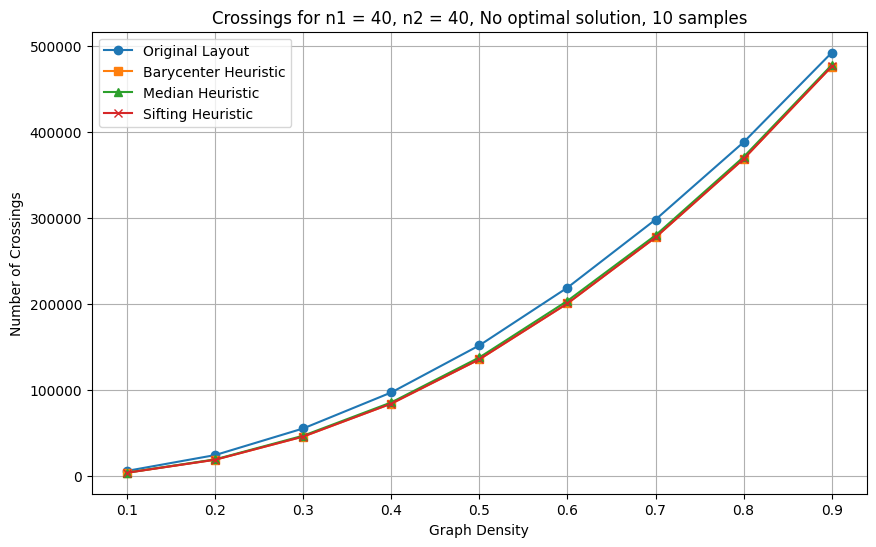

In [15]:
# Convert results to a DataFrame for analysis
df = pd.DataFrame(results)

# Display results
print(df.to_string(index=False))

# Save the dataframe to a CSV file
df.to_csv(f'exp2_results_{n1_values[0]}+{n2_values[0]}.csv', index=False)

print("Results saved to 'exp2_results.csv'.")

# Call the plot function after results are stored
plot_results(df, f"No optimal solution, {num_samples} samples")

In [16]:
"""
# Unused Code       
for n1 in n1_values:
for n2 in n2_values:
    for p in p_values:
        result = {
            "n1": n1,
            "n2": n2,
            "density": None,
            "avg_crossings_original": 0,
            "avg_crossings_barycenter": 0,
            "avg_crossings_median": 0,
            "avg_crossings_sifting": 0,
            "avg_crossings_optimal": 0
        }
        nodes, edges, B, top_nodes, bottom_nodes = forced_density_gen_bip_graph(n1, n2, p)
        draw_horizontal_bipartite(B, top_nodes, bottom_nodes, f"Original Layout {p} density", bottom_nodes)
        
        # Calculate density, not yet bipartite
        # density = nx.density(B)
        density = bipartite.density(B, set(top_nodes))
        print(f"Density forced {p}, Density actual {density}")
        # total_density += density
        # Visualize the graph (optional, for small graphs)
        
        # Original layout
        pos_original = nx.bipartite_layout(B, top_nodes, align="horizontal")
        crossings_original = count_crossings(B, pos_original)
        # Parse the edges into (top_node, bottom_node) tuples before passing to the barycenter function
        parsed_edges = parse_edges(edges, top_nodes, bottom_nodes)
        
        # Apply Barycenter heuristic to reorder bottom nodes
        bottom_nodes_bary = barycenter(bottom_nodes, top_nodes, parsed_edges)

        # Update positions: top nodes fixed, bottom nodes reordered
        pos_barycenter = update_positions(top_nodes, bottom_nodes_bary)
        crossings_barycenter = count_crossings(B, pos_barycenter)
        
        # Apply Median heuristic to reorder bottom nodes
        bottom_nodes_median = median(bottom_nodes, top_nodes, parsed_edges)

        # Update positions: top nodes fixed, bottom nodes reordered
        pos_median = update_positions(top_nodes, bottom_nodes_median)
        crossings_median = count_crossings(B, pos_median)


        # Apply Simple Sifting heuristic to reorder bottom nodes
        sifting_heuristic = sifting(bottom_nodes, top_nodes, edges, verbose=0, )
        # draw_horizontal_bipartite(B, top_nodes, bottom_nodes, f"Sifting Layout {p} density", sifting_heuristic)
        # draw_horizontal_bipartite(B, top_nodes, sifting_heuristic, "After Sift Algorithm") ## bug spotted, i also commented a code out in sifting
        pos_sifting = update_positions(top_nodes, sifting_heuristic) # the sifting_heuristic is 1,2,3,4,5 while the previous ones have 'u1, u2,..' 
        
        # print("POS_SIFTING", pos_sifting)
        
        crossings_sifting = count_crossings(B, pos_sifting)
        # crossings_sifting = cross_count(top_nodes, sifting_heuristic,edges)
        
        
        result["density"] = density
        result["avg_crossings_original"] = crossings_original
        result["avg_crossings_barycenter"] = crossings_barycenter
        result["avg_crossings_median"] = crossings_median
        result["avg_crossings_sifting"] = crossings_sifting
        results.append(result)
"""

'\n# Unused Code       \nfor n1 in n1_values:\nfor n2 in n2_values:\n    for p in p_values:\n        result = {\n            "n1": n1,\n            "n2": n2,\n            "density": None,\n            "avg_crossings_original": 0,\n            "avg_crossings_barycenter": 0,\n            "avg_crossings_median": 0,\n            "avg_crossings_sifting": 0,\n            "avg_crossings_optimal": 0\n        }\n        nodes, edges, B, top_nodes, bottom_nodes = forced_density_gen_bip_graph(n1, n2, p)\n        draw_horizontal_bipartite(B, top_nodes, bottom_nodes, f"Original Layout {p} density", bottom_nodes)\n        \n        # Calculate density, not yet bipartite\n        # density = nx.density(B)\n        density = bipartite.density(B, set(top_nodes))\n        print(f"Density forced {p}, Density actual {density}")\n        # total_density += density\n        # Visualize the graph (optional, for small graphs)\n        \n        # Original layout\n        pos_original = nx.bipartite_layout(B, 